# [SISEPUEDE_CALIBRATION](https://github.com/milocortes/sisepuede_calibration/tree/test)

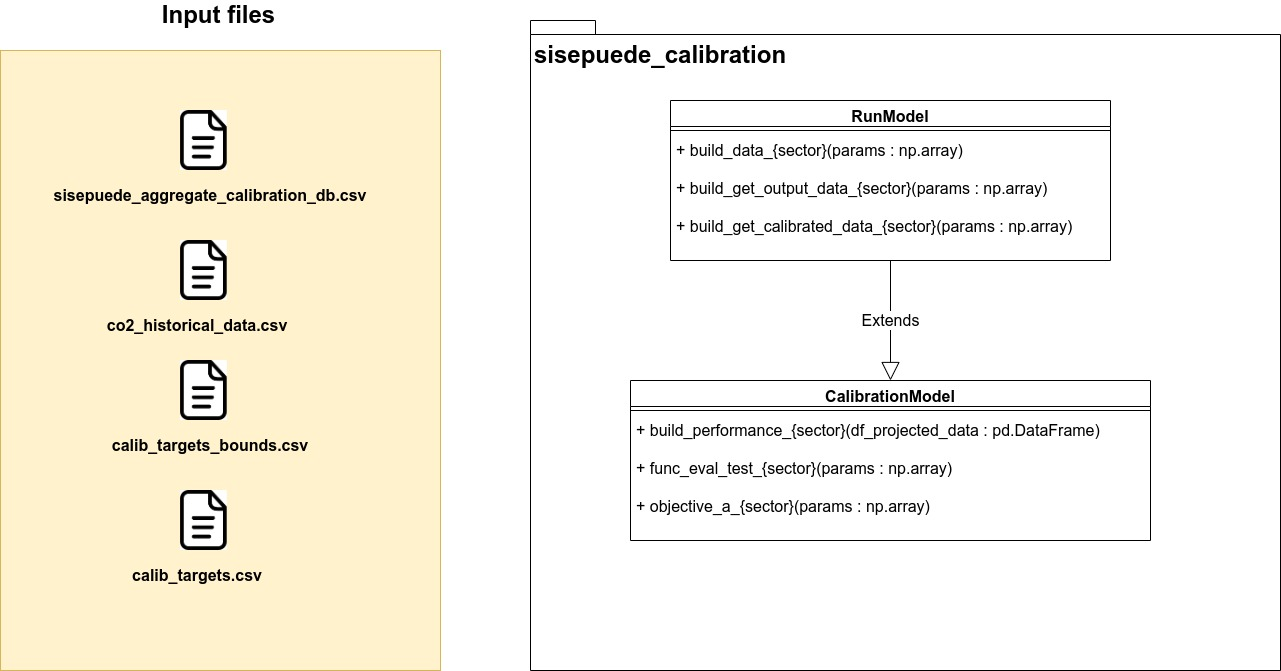

# build_data_{sector}

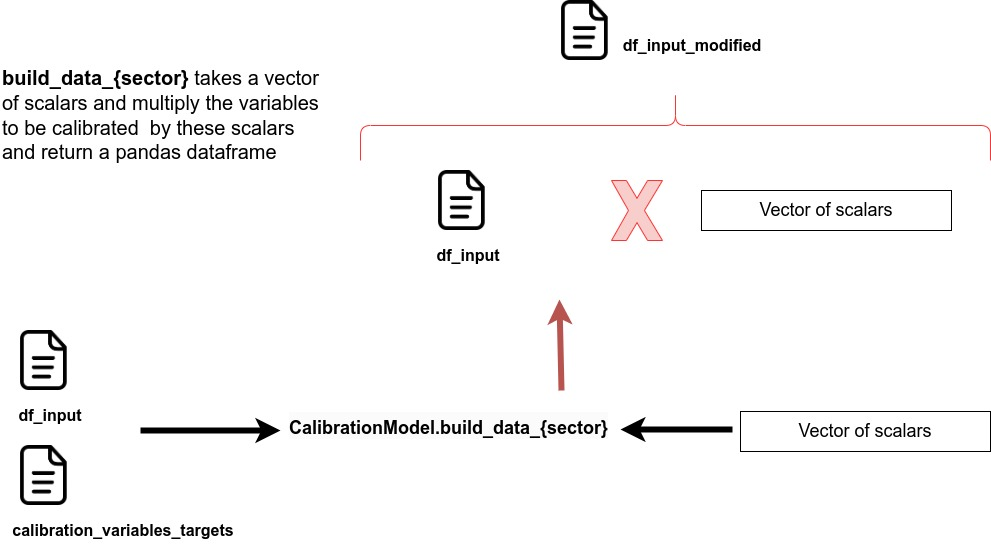

# get_output_data_{sector} method

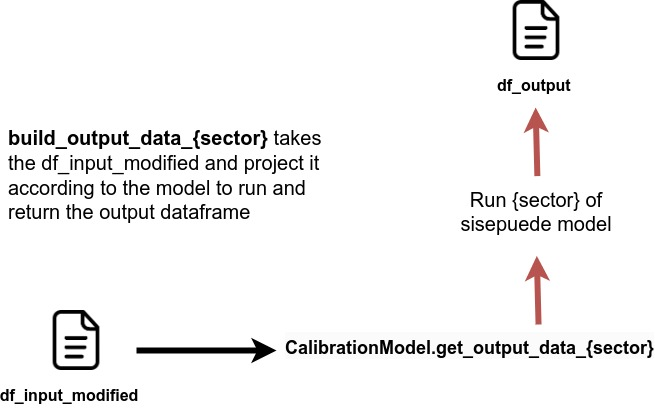

# get_performance_{sector}

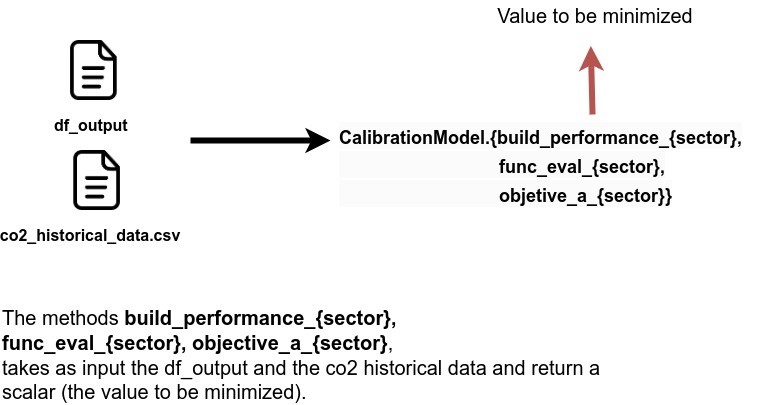

# build_calibrated_data_{sector}

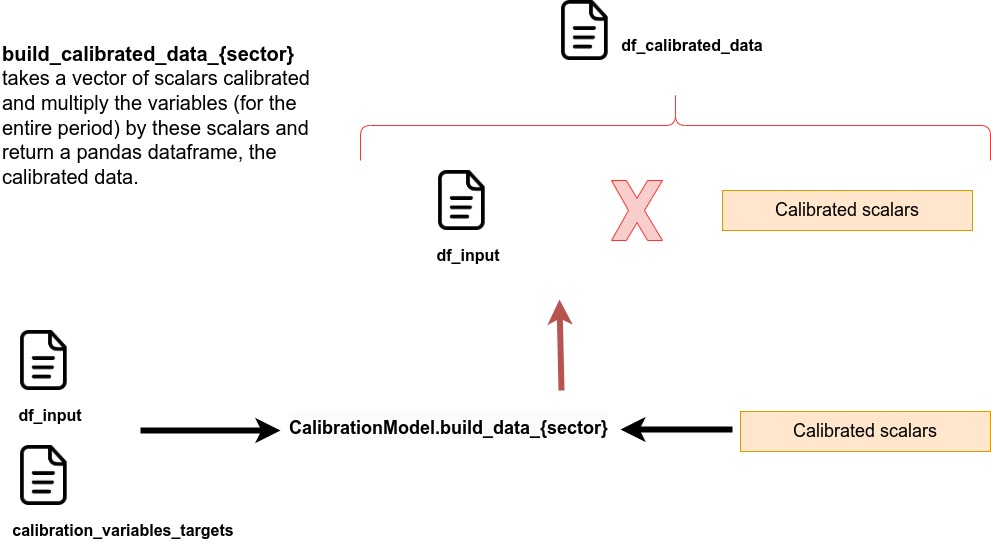

# build_performance_{sector} method

The build_performance_{sector} method implements the function to minimize for each model.

In order to change the behaviour this function, decorators are used ([link](https://github.com/milocortes/sisepuede_calibration/blob/test/sisepuede_calibration/calibration_decorators/dec_performance_metrics.py)). In these decorators the function to be minimized of each sector is defined.



# AFOLU objetive function 

Minimize sum of MSE FAO Items 5058, 5059, 5060, 5061, 5062, 5063, 5064, 5066, 6729, 6750, 6751, 6992. 

$$
\begin{equation}
    \begin{aligned}
        \min MSE_{5058} + MSE_{5059} + MSE_{5060} + \dots +  MSE_{6992}  
    \end{aligned}
\end{equation}
$$

## AFOLU crosswalk
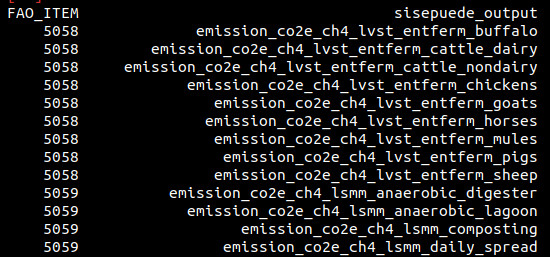

# CircularEconomy objetive function 

Minimize MSE of the fields "emission_co2e_subsector_total_wali", "emission_co2e_subsector_total_waso", "emission_co2e_subsector_total_trww" versus historical CO2 Circular Economy sector.

$$
\begin{equation}
    \begin{aligned}
        \min MSE_{CircularEconomy}   
    \end{aligned}
\end{equation}
$$


# IPPU objetive function 

Minimize MSE of the field emission_co2e_subsector_total_ippu versus historical CO2 IPPU sector.

$$
\begin{equation}
    \begin{aligned}
        \min MSE_{IPPU}   
    \end{aligned}
\end{equation}
$$


# Energy objetive function 

Minimize sum of MSE subsectors entc, fgtv, inen, scoe, trns against their historical CO2 values. 

$$
\begin{equation}
    \begin{aligned}
        \min MSE_{entc} + MSE_{fgtv} + MSE_{inen} +  MSE_{scoe} + MSE_{trns}  
    \end{aligned}
\end{equation}
$$

## Energy crosswalk

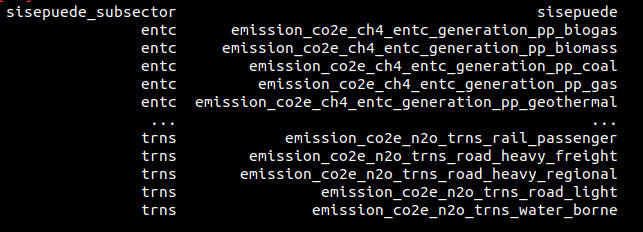

# EXAMPLE

In [ ]:
import os

os.environ['LAC_PATH'] = '/home/milo/Documents/egap/calibration/lac_decarbonization'

import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle

from sisepuede_calibration.calibration_lac import CalibrationModel

In [ ]:
# Set directories
dir_path = os.getcwd()
data_path = os.path.abspath(os.path.join(dir_path,"..","data","inputs_sisepuede" ))
save_data_path = os.path.abspath(os.path.join(dir_path,"..","output" ))

# Correspondence iso code 3 - SISEPUEDE
iso3_codes_lac = ["ARG", "BHS", "BRB", "BLZ", "BOL", "BRA", "CHL", "COL", "CRI", "DOM", "ECU", "SLV", "GTM", "GUY", "HTI", "HND", "JAM", "MEX", "NIC", "PAN", "PRY", "PER", "SUR", "TTO", "URY", "VEN"]
country_names_lac = ['argentina', 'bahamas', 'barbados', 'belize', 'bolivia', 'brazil', 'chile', 'colombia', 'costa_rica', 'dominican_republic', 'ecuador', 'el_salvador', 'guatemala', 'guyana', 'haiti', 'honduras', 'jamaica', 'mexico', 'nicaragua', 'panama', 'paraguay', 'peru', 'suriname', 'trinidad_and_tobago', 'uruguay', 'venezuela']

correspondece_iso_names = {x:y for x,y in zip(iso3_codes_lac, country_names_lac)}

# Load input data sisepuede_aggregate_calibration_db_20220303.csv
df_input_all_countries = pd.read_csv( os.path.join(data_path, "sisepuede_aggregate_calibration_db_20220303.csv"))


In [ ]:
# Define target country
target_country = "BRA"

#### Load calib targets by model to run
## Calib bounds
df_calib_targets =  pd.read_csv( os.path.join(data_path, "calib_bounds_sector.csv") )

### Load calib targets
calib_targets_all_sectors =  pd.read_csv( os.path.join(data_path, "calib_targets_all_sectors.csv") )

# Load observed CO2 data
df_co2_observed_data = {"AFOLU" : pd.read_csv(os.path.join(data_path, "emissions_targets_promedios_iso_code3.csv")),
                        "CircularEconomy": pd.read_csv(os.path.join(data_path, "ghg_LAC_circular_ippu_iso_code3.csv")),
                        "IPPU" : pd.read_csv(os.path.join(data_path, "ghg_LAC_circular_ippu_iso_code3.csv")),
                        "AllEnergy" : pd.read_csv(os.path.join(data_path, "ghg_LAC_energy_iso_code3.csv"))}


# Define lower and upper time bounds
year_init,year_end = 0,5

# Subset input data
df_input_country = df_input_all_countries.query("iso_code3 =='{}' and (time_period>={} and time_period<={})".format(target_country,year_init,year_end)).reset_index().drop(columns=["index"])

df_input_country_all_time_period = df_input_all_countries.query("iso_code3 =='{}'".format(target_country)).reset_index().drop(columns=["index"])


## RUN AFOLU CALIBRATION

In [ ]:
# Set model to run
models_run = "AFOLU"

# AFOLU calibration targets
calib_targets_afolu = calib_targets_all_sectors.query(f"sector =='{models_run}'")["calib_targets"].reset_index(drop = True)

# AFOLU CO2 observed data
df_co2_observed_data_afolu = df_co2_observed_data[models_run].query("model == '{}' and iso_code3=='{}' and (Year >= {} and Year <= {} )".format(models_run,target_country,year_init+2014,year_end+2014))


# AFOLU FAO crosswalk co2 - SISEPUEDE
import json

AFOLU_fao_correspondence = json.load(open(os.path.join(data_path,"AFOLU_fao_correspondence.json"), "r"))
AFOLU_fao_correspondence = {k:v for k,v in AFOLU_fao_correspondence.items() if v}

# Instance CalibrationModel object
calibration = CalibrationModel(year_init+2014, year_end +2014, df_input_country, correspondece_iso_names[target_country], models_run,
                                calib_targets_afolu, df_calib_targets, df_calib_targets, df_input_country_all_time_period,
                                df_co2_observed_data_afolu,AFOLU_fao_correspondence,cv_training = [0,1,2,3,4,5] ,cv_calibration = False,precition=4)

In [ ]:
# Setup optimization algorithm parameters and run calibration with PSO  
param_algo = {"alpha" : 0.5, "beta" : 0.8}
calibration.run_calibration("pso", population = 10, maxiter = 10, param_algo = param_algo)

# Get calibration vector
calibration_vector_AFOLU = calibration.best_vector["AFOLU"]


## RUN CircularEconomy CALIBRATION


In [ ]:
# Set model to run
models_run = "CircularEconomy"

# CircularEconomy calibration targets
calib_targets_circular_economy = calib_targets_all_sectors.query(f"sector =='{models_run}'")["calib_targets"].reset_index(drop = True)

# CircularEconomy CO2 observed data
df_co2_observed_data_circular_economy = df_co2_observed_data[models_run].query("model == '{}' and iso_code3=='{}' and (Year >= {} and Year <= {} )".format(models_run,target_country,year_init+2014,year_end+2014))

# Instance of CalibrationModel
calibration_circ_ec = CalibrationModel(year_init, year_end, df_input_country, correspondece_iso_names[target_country], models_run,
                                calib_targets_circular_economy, df_calib_targets, df_calib_targets, df_input_country_all_time_period,
                                df_co2_observed_data_circular_economy, cv_training = [0,1,2,3,4,5] ,cv_calibration = False,precition=4, run_integrated_q = True)

# Set calibrated vector for each sector estimated
calibration_circ_ec.set_best_vector("AFOLU",calibration_vector_AFOLU)

In [ ]:
# Setup optimization algorithm parameters and run calibration with PSO  
parameters_algo = {"alpha" : 0.5, "beta" : 0.8}
calibration_circ_ec.run_calibration("pso", population = 10, maxiter = 10, param_algo = parameters_algo)

# Get calibration vector
calibration_vector_CircularEconomy = calibration_circ_ec.best_vector["CircularEconomy"]


## RUN IPPU CALIBRATION


In [ ]:
# Set model to run
models_run = "IPPU"

# IPPU calibration targets
calib_targets_ippu = calib_targets_all_sectors.query(f"sector =='{models_run}'")["calib_targets"].reset_index(drop = True)

# IPPU CO2 observed data
df_co2_observed_data_ippu = df_co2_observed_data[models_run].query("model == '{}' and iso_code3=='{}' and (Year >= {} and Year <= {} )".format(models_run,target_country,year_init+2014,year_end+2014))

# Instance of CalibrationModel
calibration_ippu = CalibrationModel(year_init, year_end, df_input_country, correspondece_iso_names[target_country], models_run,
                                calib_targets_ippu, df_calib_targets, df_calib_targets, df_input_country_all_time_period,
                                df_co2_observed_data_ippu, cv_training = [0,1,2,3,4,5] ,cv_calibration = False,precition=4, run_integrated_q = True)


# Set calibrated vector for each sector estimated
calibration_ippu.set_best_vector("AFOLU",calibration_vector_AFOLU)
calibration_ippu.set_best_vector("CircularEconomy",calibration_vector_CircularEconomy)
calibration_ippu.set_calib_targets("CircularEconomy", calib_targets_circular_economy)


In [ ]:

# Setup optimization algorithm parameters and run calibration with PSO  
parameters_algo = {"alpha" : 0.5, "beta" : 0.8}
calibration_ippu.run_calibration("pso", population = 10, maxiter = 10, param_algo = parameters_algo)

# Get calibrated vector
calibration_vector_IPPU = calibration_ippu.best_vector["IPPU"]

## RUN AllEnergy CALIBRATION


In [ ]:
# Set model to run
models_run = "AllEnergy"

## Load Energy crosswalk
import json
energy_correspondence = json.load(open(os.path.join(data_path, "energy_subsector_items.json") , "r"))

# AllEnergy calibration targets
calib_targets_energy = calib_targets_all_sectors.query(f"sector =='{models_run}'")["calib_targets"].reset_index(drop = True)


# AllEnergy CO2 observed data
energy_observado = df_co2_observed_data[models_run].query(f"iso_code3=='{target_country}' and (variable >= 2014 and variable <=2019)").reset_index(drop = True)


# Instance of CalibrationModel
calibration_Allenergy = CalibrationModel(year_init, year_end, df_input_country, correspondece_iso_names[target_country], models_run,
                                df_calib_targets, df_calib_targets, df_calib_targets, df_input_country_all_time_period,
                                energy_observado, energy_correspondence, cv_training = [0,1,2,3,4,5] ,cv_calibration = False,precition=4, run_integrated_q = True)


In [ ]:
# Set calibrated vector for each sector estimated
calibration_Allenergy.set_best_vector("AFOLU",calibration_vector_AFOLU)

calibration_Allenergy.set_best_vector("CircularEconomy",calibration_vector_CircularEconomy)
calibration_Allenergy.set_calib_targets("CircularEconomy", calib_targets_circular_economy)

calibration_Allenergy.set_best_vector("IPPU",calibration_vector_IPPU)
calibration_Allenergy.set_calib_targets("IPPU", calib_targets_ippu)

In [ ]:
### ENERGY CALIBRATION

print("INICIA LA CALIBRACION DE ENERGIA")

from optimization_algorithms import PSO

# Tamaño de la población
n = 2

# Número de variables
n_var = len(calib_targets_energy)
l_bounds = np.array(df_calib_targets[df_calib_targets["variable"].isin(calib_targets_energy)]["min_35"])
u_bounds = np.array(df_calib_targets[df_calib_targets["variable"].isin(calib_targets_energy)]["max_35"])
maxiter =  1
# Social scaling parameter
α = 0.8
# Cognitive scaling parameter
β = 0.8
# velocity inertia
w = 0.5

fitness_pso, x_best_pso = PSO(calibration_Allenergy.f, n, maxiter, n_var, l_bounds, u_bounds, α, β, w)

output_data_AllEnergy = calibration_Allenergy.get_output_data(x_best_pso, print_sector_model = True)
calibrated_data_AllEnergy = calibration_Allenergy.get_calibrated_data(x_best_pso, print_sector_model = True)
calibrated_data_AllEnergy["iso_code3"] = target_country
calibrated_data_AllEnergy = calibrated_data_AllEnergy[["time_period","iso_code3"]+[i for i in calibrated_data_AllEnergy.columns if i not in ["time_period","iso_code3"]]]
